#1. detect active / rest 

#A[Start with mot_en] --> B[Extract segments active/rest<br/

#2. detect tw 

    # A[Start with putative_twitch_binary] --> B[Extract segments<br/>(onset, offset pairs)]
    # B --> C[Filter 1: Awake Proximity<br/>Exclude segments whose onset is within 3 sec (9 frames)<br/>of any motion (active state) frame]
    # C --> D[Filter 2: Duration<br/>Keep only segments with duration ≥ 1 sec (≥ 3 frames)]
    # D --> E[Filter 3: Burstiness<br/>Remove segments whose onsets are < 3 sec apart (9 frames)]
    # E --> F[Create final DataFrame with:<br/>- Onset<br/>- Offset<br/>- Duration (frames & sec)]
    # F --> G[Export to Excel]

In [45]:
import os
# going to root directory (if not there yet)
current_dir = os.getcwd().split('/')[-1]
if current_dir != 'mouse_motion_analysis': 
    os.chdir('..')

In [46]:
os.getcwd()

'C:\\Users\\zaggila\\Documents'

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tifffile
from skimage import filters
from scipy.ndimage import label, binary_closing

from pathlib import Path
from PIL import Image
import imageio
import cv2

from src.data_io import *
from src.videography_compute import *
from src.videography_plot import *

In [48]:
os.getcwd()

'C:\\Users\\zaggila\\Documents'

In [49]:
# setting common plot params 
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [50]:
def mkdir(path):
    if not os.path.exists(path): os.makedirs(path)
    return path

In [51]:
data_path = rf'C:\Users\zaggila\Documents\pixelNMF\data'
sessions = sorted([f for f in os.listdir(data_path) if f.endswith('_cell_control')])
print(f'All sessions: {sessions}')

All sessions: ['sz89_2024-06-04_a_cell_control', 'sz89_2024-06-06_a_cell_control', 'sz89_2024-06-07_a_cell_control', 'sz90_2024-06-05_a_cell_control', 'sz90_2024-06-06_a_cell_control', 'sz90_2024-06-07_a_cell_control', 'sz91_2024-06-05_b_cell_control', 'sz92_2024-06-06_a_cell_control', 'sz92_2024-06-07_a_cell_control']


In [52]:
ds = 'sz89_2024-06-06_a_cell_control'

subject_path = os.path.join(data_path, ds) # choose one specifc ds 
movie_path = os.path.join(subject_path, 'cam_crop.tif')

#load sleap output
files = os.listdir(subject_path)
csv_files = [f for f in files if f.endswith('.csv')]

# Check if there is exactly one CSV file
if len(csv_files) == 1:
    # Load the CSV file into a DataFrame
    sleap_output_path = os.path.join(subject_path, csv_files[0])  # Get full path to the CSV file
    sleap_output = pd.read_csv(sleap_output_path)  # Pass the file path
    print(f"Loaded {csv_files[0]}")
else:
    if len(csv_files) == 0:
        raise FileNotFoundError("No CSV files found")
    else:
        raise FileExistsError("Multiple CSV files found. Please ensure there is only one CSV file in the subject directory.")

save_dir = subject_path
save_dir_videography = mkdir(f'{save_dir}/videography_processing')
save_dir_videography = Path(save_dir_videography)

Loaded sz89_2024-06-06_a_analysis.csv


# Set parameters 

In [53]:
gaussian_sigma = 3

# Thresholds for binarisation
threshold_binary = 'otsu'  # threshold for binary: a/r state detcetion -
threshold_twitch = 'li' #threshold for twitch detection (more permissive -> detect more/lose less)
# thresh_factor = 1.0  # used for "mean+std" option

# Twitch detection thresholds
framerate = 3  # Hz

active_motion_duration_min = framerate * 1 # 1 sec 
long_active_motion_duration_min = framerate * 3 # at least 3 seconds to be considered a long awake motion eg run 
twitch_duration_max = active_motion_duration_min
twitch_min_distance_from_active = framerate * 3  # at least 3 sec away from awake motion to be detected as twitch 
print(f' max_twitch_allowed: {twitch_duration_max/framerate} sec') 

 max_twitch_allowed: 1.0 sec


# Compute/Load motion energy

Motion energy already computed. Loading from C:\Users\zaggila\Documents\pixelNMF\data\sz89_2024-06-06_a_cell_control\motion_energy.npy


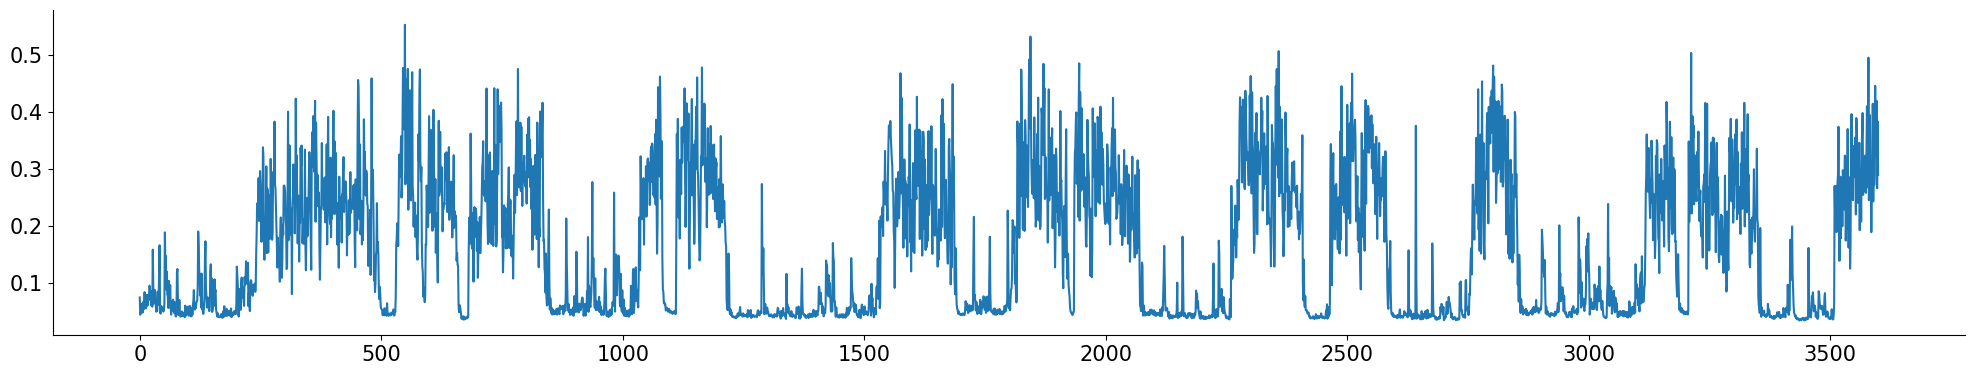

In [54]:
motion_energy = compute_motion_energy(movie_path=movie_path, xrange=None, yrange=None, save_path=subject_path) #if first run, provide movie_path

if len(motion_energy) != 3600:
    motion_energy = pad(motion_energy)
    motion_energy = average_frames(motion_energy, avg_block = 5)

plt.plot(motion_energy)
plt.show()

In [55]:
length_acts = len(motion_energy)
# for plotting xticks to seconds
frame_ticks = range(0, length_acts+ 100, 300)  # 300 frames is 100 sec
second_ticks = [int(tick/framerate) for tick in frame_ticks]   # Convert to seconds

# Smooth motion energy

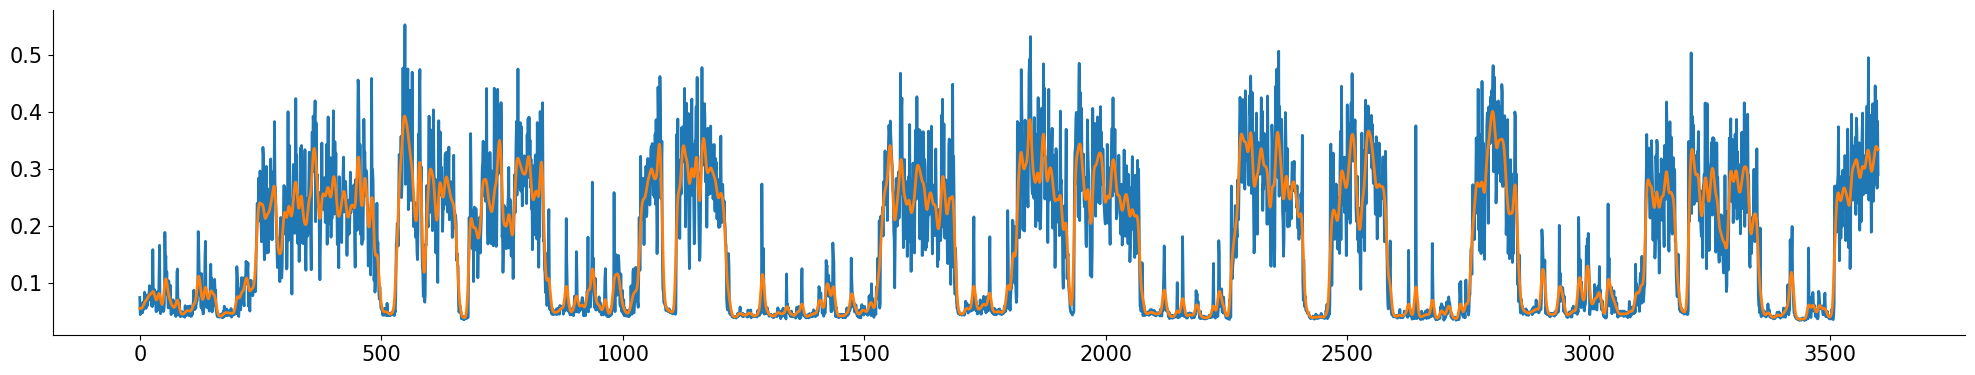

In [56]:
# Smooth motion energy
smoothed_motion_energy = smooth_with_gaussian(motion_energy, sigma=gaussian_sigma)

plt.plot(motion_energy, linewidth=2)
plt.plot(smoothed_motion_energy, linewidth=2)
plt.show()

In [57]:
# from scipy.signal import savgol_filter

# motion_energy_smooth_savgol = savgol_filter(motion_energy, window_length=10, polyorder=2)
# plt.plot(motion_energy)
# plt.plot(motion_energy_smooth_savgol, c='lime')
# plt.plot(smoothed_motion_energy, c='r')

# plt.show()

# Choose statistical threshold for binarisation 

In [58]:
def compute_thresholds_for_bin_state_detection(motion_signal, title='', save_dir=None, plot=True):
    '''
    Compute statistical thresholds to use for threshold-based state detection (active/awake - rest)
    Here we use: Otsu (prefer if binary distribution), Li (mutliple peak distribution), or mean+sd (gaussian distribution)
    '''
    
    # mean+sd threshold 
    motion_mean = np.mean(motion_signal)
    motion_sd = np.std(motion_signal)

    threshold_motion_mean_sd = motion_mean + motion_sd

    threshold_motion_li = filters.threshold_li(motion_signal)

    threshold_motion_otsu = filters.threshold_otsu(motion_signal)

    if plot:
        plt.figure(figsize=(5, 5), dpi=300)
        plt.title(f'{title}')
        plt.hist(motion_signal, bins=70, alpha=0.9)

        # mark threshold lines
        plt.axvline(x=threshold_motion_mean_sd, color='red', label='mean + sd', linestyle='--')
        plt.axvline(x=threshold_motion_otsu, color='salmon', label='Otsu', linestyle='--')
        plt.axvline(x=threshold_motion_li, color='darkred', label='Li', linestyle='--')

        plt.legend()
        plt.savefig(save_dir / f'{title}.png')
        plt.show()

    return threshold_motion_mean_sd, threshold_motion_li, threshold_motion_otsu

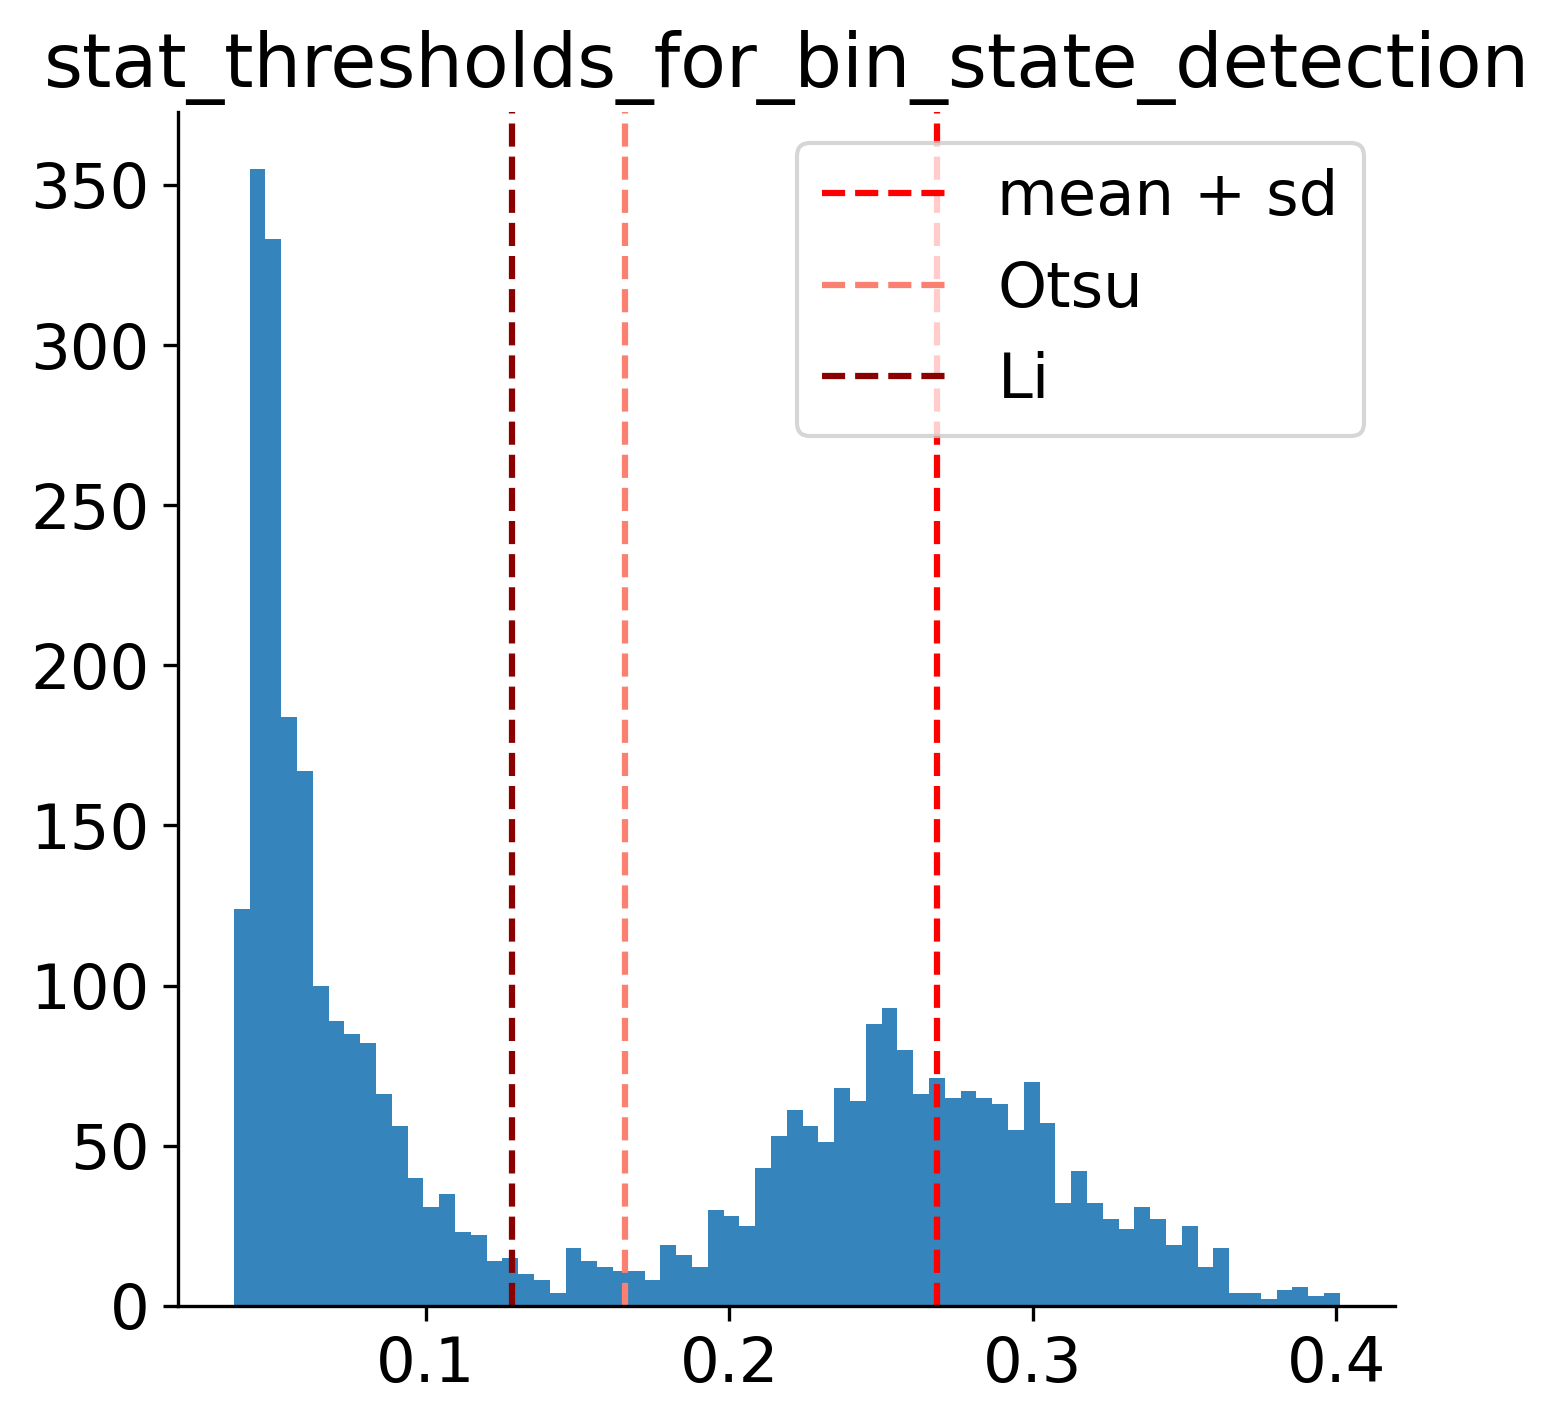

In [59]:
threshold_motion_mean_sd, threshold_motion_li, threshold_motion_otsu = compute_thresholds_for_bin_state_detection(smoothed_motion_energy, title='stat_thresholds_for_bin_state_detection', save_dir=save_dir_videography, plot=True)

# Choose binarisation threshold 

In [60]:
binary_threshold = threshold_motion_otsu

# Binarise motion energy

In [61]:
def binarise_motion(motion_signal, binary_threshold, min_duration, min_inactive_gap=9):
    '''
    Binarises motion signal (eg mot_en) into 0s (rest) and 1s (active)
    input params:
    motion_signal: motion energy or other
    binary_threshold: sts threshold (li, otsu or mean_sd for state detection)
    min_duration: min_duration threshold to be detected as awake/active motion
    
    returns:
    bin_motion_signal: bin array of 0s and 1s 
    inds_active_state: indices of frames whens state is active
    inds_rest_state: indices of frames when state is rest/inactive 

    '''
    
    bin_motion_signal = np.zeros(len(motion_signal), dtype=int)

    # get boolean array 
    
    all_active_motions_detected = motion_signal > binary_threshold 

    # labels continuous segments that pass the threshold 

    labeled_array, n_features = label(all_active_motions_detected) #how many active motions where found 
    
    for i in range(1, n_features+1):
        segment = np.where(labeled_array == i)[0]
        if len(segment) > min_duration:
            bin_motion_signal[segment] = 1 # set to active if lasts more than 1 sec approx 

    inds_active_state = np.where(bin_motion_signal ==1)
    inds_rest_state = np.where(bin_motion_signal ==0)
    
    return bin_motion_signal, inds_active_state, inds_rest_state

In [140]:
import numpy as np
from scipy.ndimage import label

def binarise_motion(motion_signal, binary_threshold, min_duration, min_inactive_gap=9):
    '''
    Binarises motion signal into 0s (rest) and 1s (active), with small inactive gaps filled.
    
    Parameters:
    - motion_signal: motion energy or similar signal
    - binary_threshold: threshold for detecting activity
    - min_duration: minimum duration (in frames) for active state
    - min_inactive_gap: fill gaps of 0s between 1s shorter than this

    Returns:
    - bin_motion_signal: binary 0/1 signal
    - inds_active_state: indices of 1s
    - inds_rest_state: indices of 0s
    '''
    
    bin_motion_signal = np.zeros(len(motion_signal), dtype=int)

    # Initial active motion detection
    all_active_motions_detected = motion_signal > binary_threshold 
    labeled_array, n_features = label(all_active_motions_detected)

    for i in range(1, n_features + 1):
        segment = np.where(labeled_array == i)[0]
        if len(segment) > min_duration:
            bin_motion_signal[segment] = 1

    # short breaks in motion within high motion -> smooth out to 1 (min_inactive_gap smoothing)
    labeled_inactive, n_inactive = label(bin_motion_signal == 0)
    for i in range(1, n_inactive + 1):
        gap = np.where(labeled_inactive == i)[0]
        if len(gap) < min_inactive_gap:
            if gap[0] > 0 and gap[-1] < len(bin_motion_signal) - 1:
                if bin_motion_signal[gap[0] - 1] == 1 and bin_motion_signal[gap[-1] + 1] == 1:
                    bin_motion_signal[gap] = 1  # fill small inactive gap

    inds_active_state = np.where(bin_motion_signal == 1)[0]
    inds_rest_state = np.where(bin_motion_signal == 0)[0]
    
    return bin_motion_signal, inds_active_state, inds_rest_state

In [141]:
bin_motion_energy, inds_active_state, inds_rest_state =  binarise_motion(smoothed_motion_energy, binary_threshold=binary_threshold, min_duration=active_motion_duration_min, min_inactive_gap=9)

# bin_motion_hmm, states, idx_active_state_hmm = classify_motion_with_hmm(motion_energy, smoothed_motion_energy, n_states=3, n_iter=10000)

In [142]:
# # plt.plot(states, color='orange', linewidth=2)
# plt.plot(bin_motion_energy, c='orange')
# plt.plot(bin_motion_hmm, c='r', alpha=0.5)
# plt.plot(motion_energy, c='b')
# plt.show()

# Plot binary motion (Active - 1 / Rest - 0)

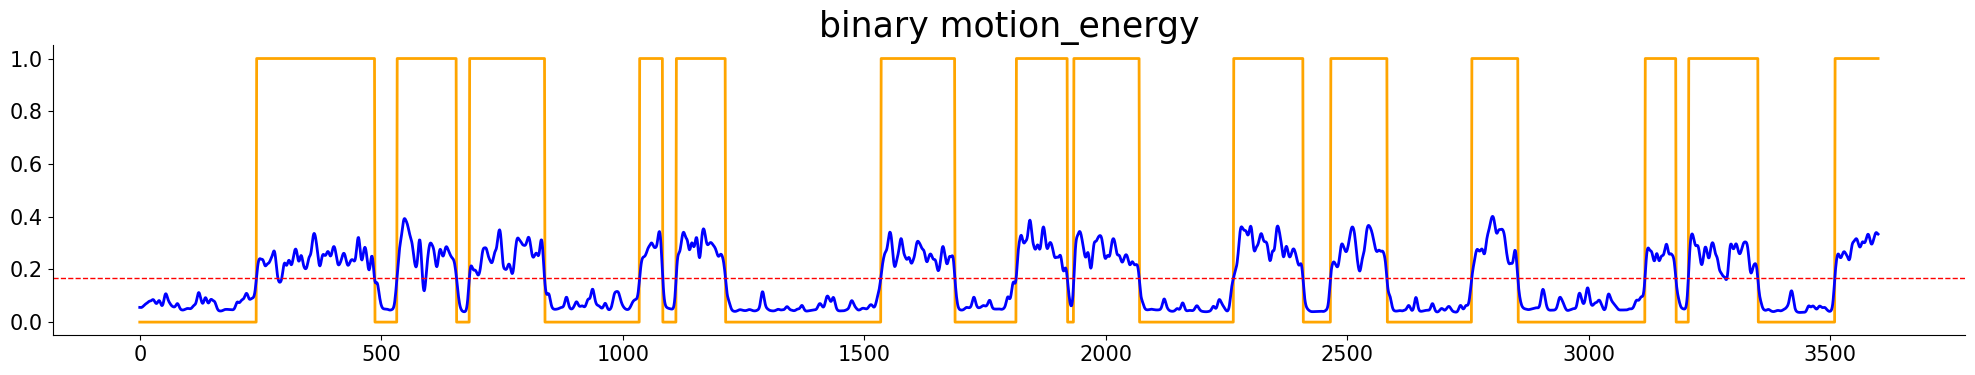

In [143]:
plt.plot(bin_motion_energy, color='orange', linewidth=2)
plt.plot(smoothed_motion_energy, color='blue', linewidth=2)
plt.title('binary motion_energy', fontsize=25)
plt.axhline(y=threshold_motion_otsu, color='red', linestyle='--', label='binary threshold', linewidth=1)
# plt.savefig(save_dir_videography + 'thresholded_binarised_motion_energy.png')
plt.show()

In [144]:
# # Compute first derivative
# diff_motion = np.gradient(motion_energy)

# # Find peaks in the derivative where slope is steep
# peaks, _ = find_peaks(diff_motion, height=some_slope_threshold)

In [145]:
# from scipy.fft import fft
# power = np.abs(fft(motion_energy[0:3600])) 

# Define onsets and offsets of active motion 

In [146]:
def get_onsets(bin_motion):
    onsets = np.where((bin_motion[1:] == 1) & (bin_motion[:-1] == 0))[0] + 1 #[0] specific to stcuture of array
    # if bin_motion[0] == 1:       
    return onsets
    
def get_offsets(bin_motion):
    offsets = np.where((bin_motion[1:] == 0) & (bin_motion[:-1] == 1))[0] + 1 #[0] specific to stcuture of array
    return offsets  

In [147]:
active_motion_onsets = get_onsets(bin_motion_energy)
active_motion_offsets = get_offsets(bin_motion_energy)

# Classify Active (awake) motions to short / long and visualise them

In [148]:
def classify_active_motion_segments(bin_motion_signal, motion_signal, short_threshold, long_threshold):
    """
    Classify active/awake motion segments into short (1–3 sec), long (>3 sec), and too short (<1 sec, those are exluded in awake motion detection and set to 0).

    Parameters:
    - bin_motion_signal: 1D array of HMM or thresholded motion states (1 for active, 0 for inactive)
    - motion_signal: 1D array of motion energy values
    - short_threshold: in frames, minimum duration for short active motions (e.g., 3 or 1s at 3Hz)
    - long_threshold: in frames, minimum duration for long active motions (e.g., 9 or 3s at 3Hz)

    Returns:
    - bin_short_active_motion: binary array marking short motions (1-3s)
    - bin_long_active_motion: binary array marking long motions (>3s)
    - bin_too_short_active_motion: binary array marking short blips (<1s)
    - and correspondings inds of long, short or too short (excluded) motions
    """
    labeled_array, num_features = label(bin_motion_signal == 1)

    bin_short_active_motion = np.zeros(len(motion_signal), dtype=int)
    bin_long_active_motion = np.zeros(len(motion_signal), dtype=int)
    bin_too_short_active_motion = np.zeros(len(motion_signal), dtype=int)

    for i in range(1, num_features + 1):
        segment = np.where(labeled_array == i)[0]

        if len(segment) > long_threshold:
            bin_long_active_motion[segment] = 1
        elif len(segment) > short_threshold:
            bin_short_active_motion[segment] = 1
        elif len(segment) > 0: # but shorter than short threshold 
            bin_too_short_active_motion[segment] = 0 # mark as inactive 

        long_active_motion_inds = np.where(bin_long_active_motion==1)[0]
        short_active_motion_inds = np.where(bin_short_active_motion==1)[0]
        too_short_active_motion_inds = np.where(bin_too_short_active_motion==1)[0]

            
    return bin_short_active_motion, short_active_motion_inds, bin_long_active_motion, long_active_motion_inds, bin_too_short_active_motion, too_short_active_motion_inds

Saved plot to: C:\Users\zaggila\Documents\pixelNMF\data\sz89_2024-06-06_a_cell_control\videography_processing\subplots_bin_motion_energy_classified.png


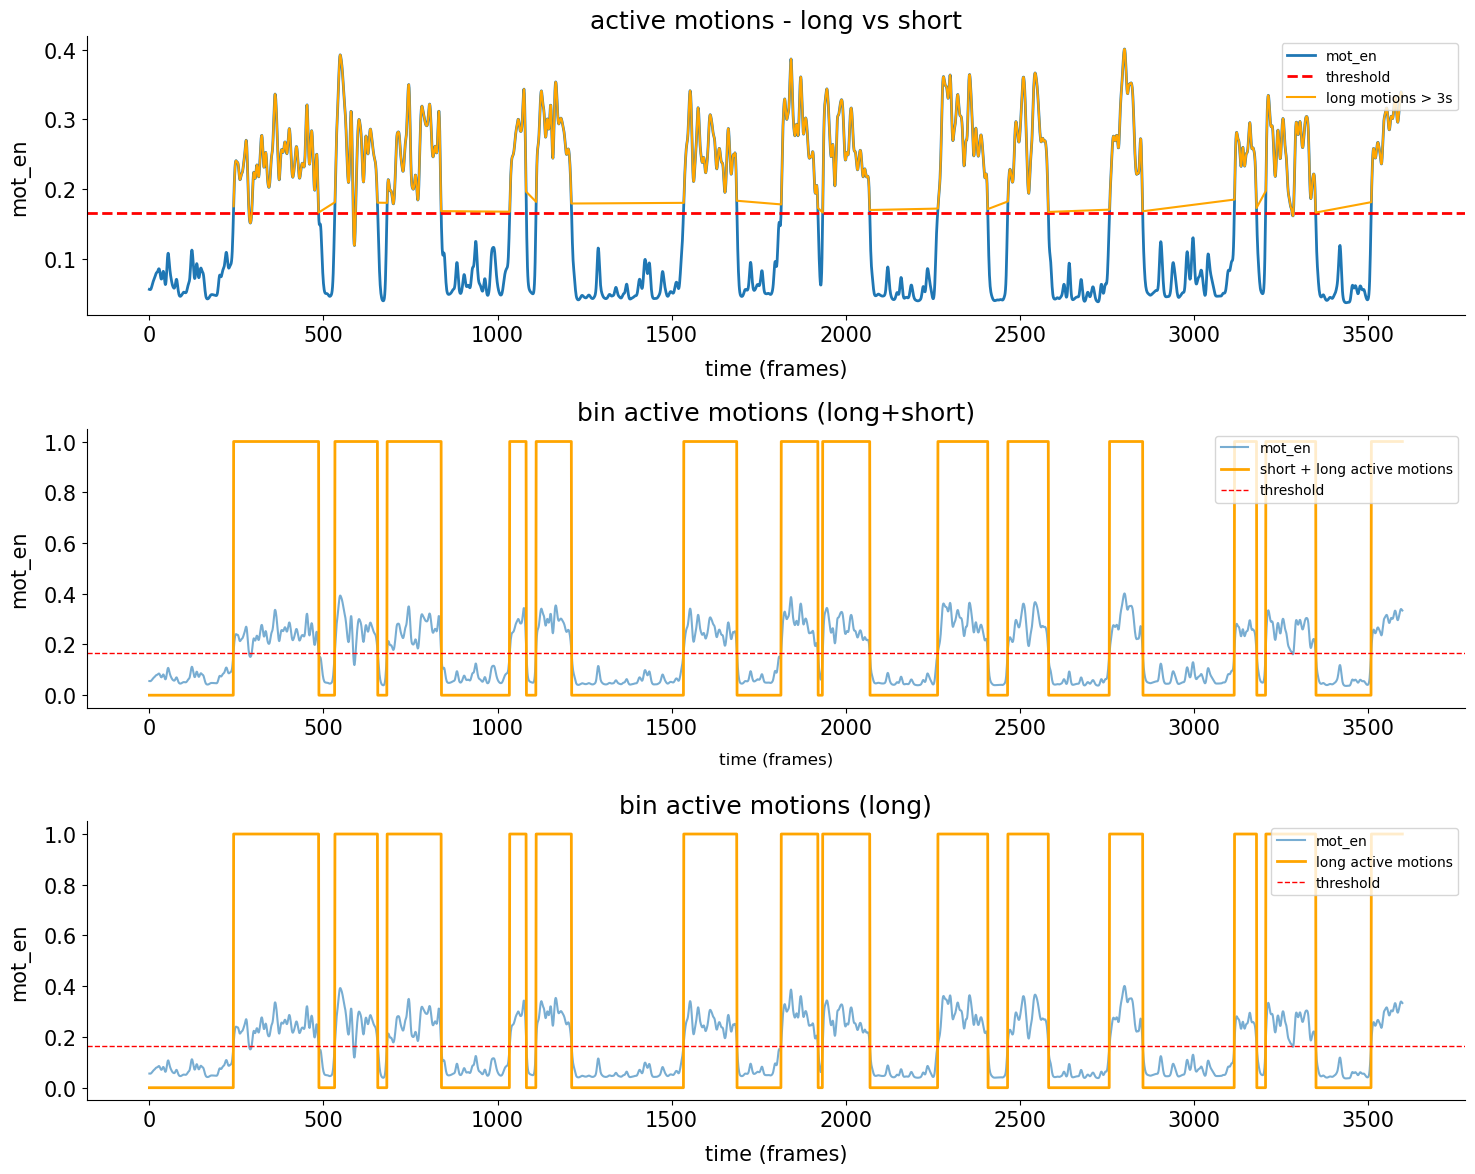

In [149]:
# classify active motions detected 
bin_short_active_motion, short_active_motion_inds, bin_long_active_motion, long_active_motion_inds, bin_too_short_active_motion, too_short_active_motion_inds = classify_active_motion_segments(
    bin_motion_energy,
    motion_energy,
    short_threshold=active_motion_duration_min,
    long_threshold=long_active_motion_duration_min
)

# plot classified active motions detected 
plot_active_motion_classification_subplots(
    motion_signal=motion_energy,
    smoothed_motion_signal=smoothed_motion_energy,
    bin_motion_energy=bin_motion_energy,
    bin_long_active_motion=bin_long_active_motion,
    bin_short_active_motion=bin_short_active_motion,
    long_active_motion_inds=long_active_motion_inds,
    short_active_motion_inds=short_active_motion_inds,
    threshold=threshold_motion_otsu,
    save_path=save_dir_videography / 'subplots_bin_motion_energy_classified.png',
)

In [152]:
type(inds_active_state)

numpy.ndarray

In [153]:
# turn indices into continuous segments eg 25-100 is active seg 1, 500-805 active seg 2 etc
active_segments = get_active_segments(inds_active_state) #all not only long
long_active_segments = get_active_segments(long_active_motion_inds) #all not only long , already numpy
# if len(short_active_segments)>1:
    # short_active_segments = get_active_segments(short_active_motion_inds)

In [154]:
print(active_segments)

[(242, 486), (533, 655), (683, 838), (1035, 1082), (1111, 1212), (1535, 1687), (1815, 1920), (1934, 2069), (2265, 2408), (2466, 2582), (2758, 2853), (3117, 3180), (3207, 3350), (3510, 3599)]


# Twitch detection 

In [155]:
rest_period = motion_energy[inds_rest_state] #identify periods of low motion energy ==0 (non smoothed (!))
rest_period = rest_period.flatten()

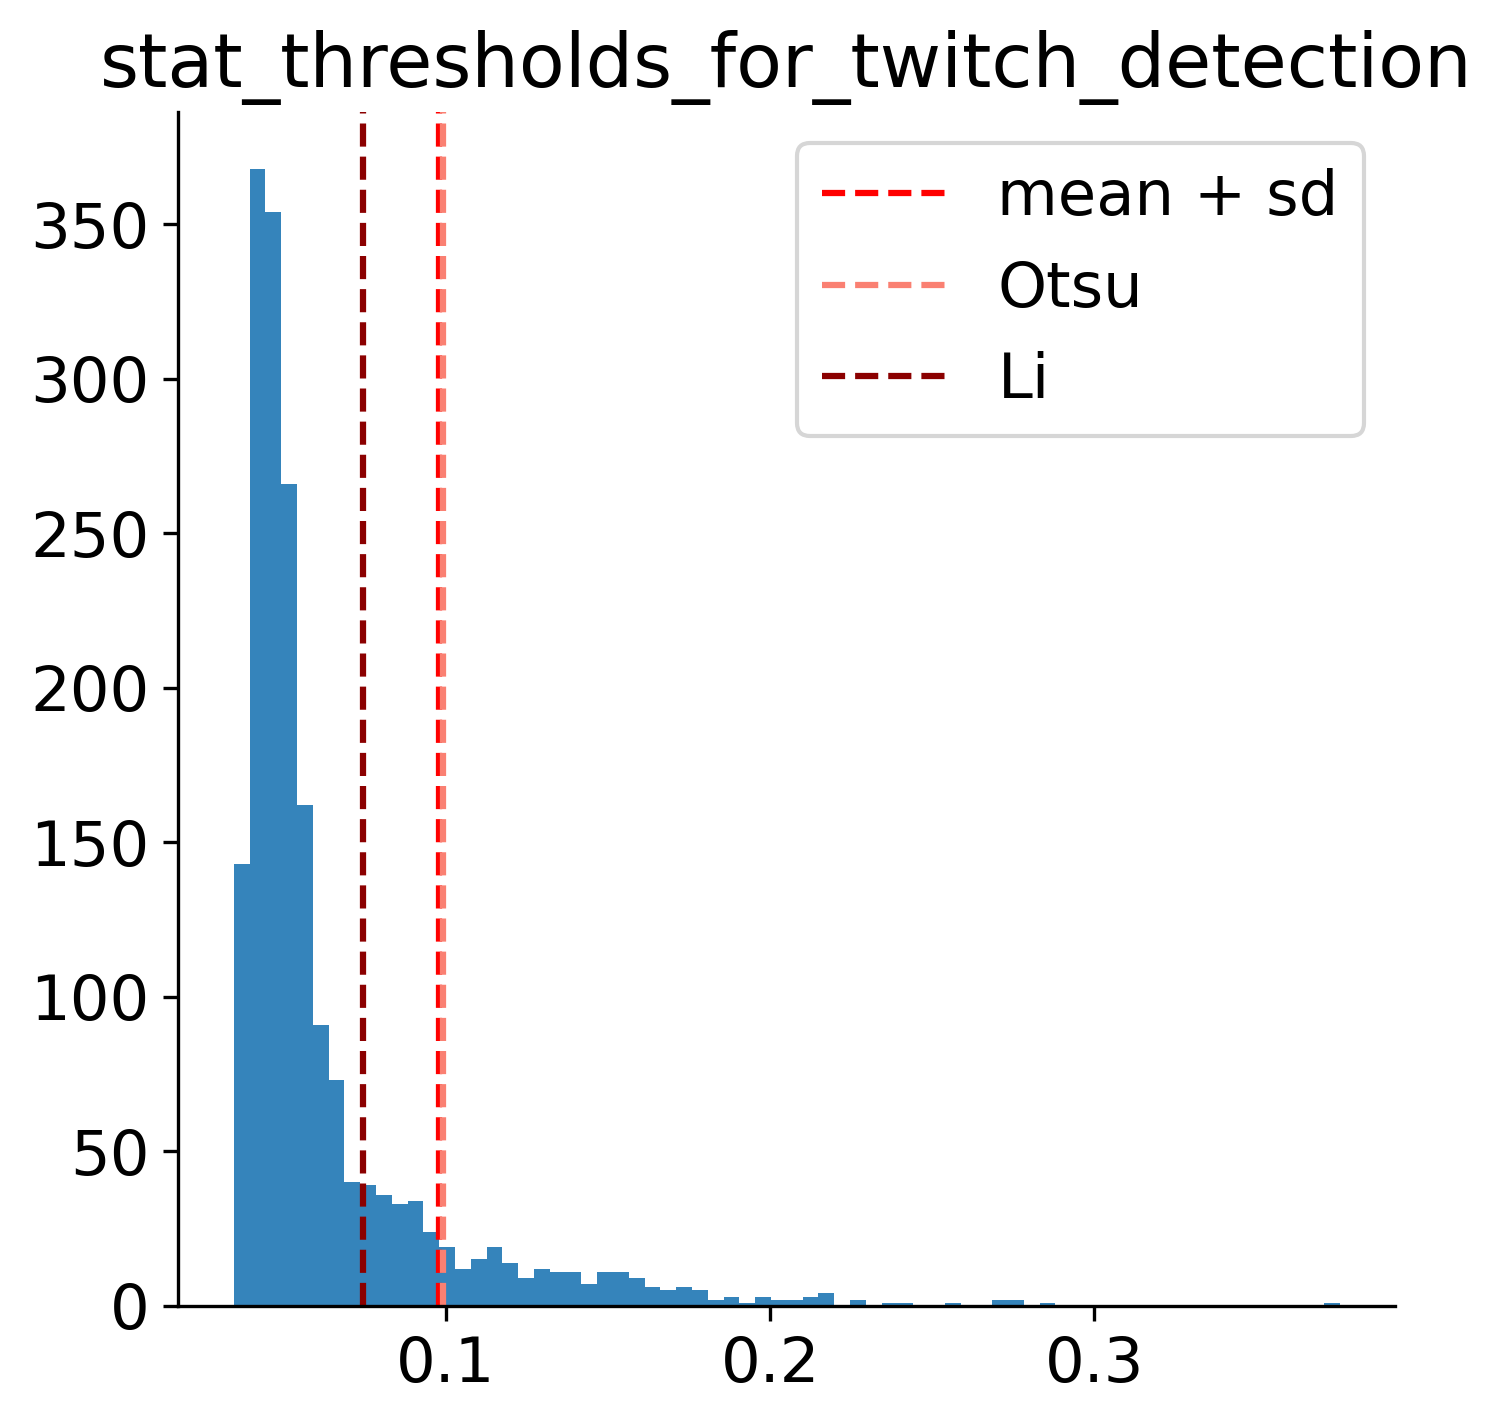

In [156]:
twitch_threshold_motion_mean_sd, twitch_threshold_motion_li, twitch_threshold_motion_otsu = compute_thresholds_for_bin_state_detection(rest_period, title='stat_thresholds_for_twitch_detection', save_dir=save_dir_videography, plot=True)

# Choose twitch threshold 

In [157]:
# choose a threshold 
twitch_threshold = twitch_threshold_motion_li #more permissive of twitches --> more twitches detected (pre-filtering)

In [159]:
inds_twitches_unfiltered = np.where(rest_period > twitch_threshold) #inds of prospective twitches (in array of low motion energy) careful its on the size of low motion array
inds_twitches_unfiltered = inds_rest_state[inds_twitches_unfiltered] 

In [160]:
len(inds_twitches_unfiltered)

374

In [161]:
unfiltered_putative_twitches_segments = find_sequential_groups(inds_twitches_unfiltered) #segs putative 
len(unfiltered_putative_twitches_segments)

140

In [162]:
def binarise_twitch(motion_energy, twitch_segments):

    # Initialize bin_twitch   
    bin_twitch = np.zeros(len(motion_energy))

    # flatten the nested list
    flat_inds = [idx for segment in twitch_segments for idx in segment] # filtered corrected twitch segments 

    print("Flattened Indices:", flat_inds)

    # Assign 1 to twitch inds
    for idx in flat_inds:
        if idx < len(motion_energy):  # Ensure index is within bounds
            bin_twitch[idx] = 1
            print(f"Assigning 1 at column {idx}")
        else:
            print(f"Skipping out-of-bounds index: {idx}")
    return bin_twitch

In [163]:
bin_putative_twitch = binarise_twitch(motion_energy, unfiltered_putative_twitches_segments) # individual frames 

Flattened Indices: [0, 10, 12, 14, 17, 18, 20, 21, 23, 27, 28, 30, 31, 37, 40, 41, 52, 53, 54, 55, 56, 57, 58, 60, 63, 77, 78, 112, 120, 121, 122, 123, 124, 125, 126, 128, 134, 135, 136, 137, 138, 141, 146, 147, 148, 149, 152, 153, 155, 156, 157, 201, 202, 203, 207, 208, 210, 211, 212, 213, 214, 217, 218, 219, 220, 221, 222, 223, 224, 226, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 487, 488, 489, 490, 491, 492, 493, 494, 495, 497, 498, 530, 531, 532, 656, 657, 658, 659, 681, 682, 839, 840, 841, 846, 847, 848, 882, 883, 884, 885, 900, 904, 905, 916, 926, 927, 928, 930, 931, 935, 936, 937, 938, 939, 940, 941, 943, 951, 963, 964, 965, 982, 983, 985, 986, 987, 988, 989, 990, 991, 992, 993, 996, 999, 1017, 1021, 1022, 1025, 1026, 1027, 1029, 1030, 1033, 1034, 1083, 1084, 1213, 1214, 1219, 1220, 1288, 1289, 1290, 1291, 1292, 1339, 1370, 1371, 1406, 1407, 1408, 1410, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429, 1435, 1436, 1437, 1473, 1474, 1475, 1476, 1510, 151

In [164]:
# get onsets 

In [165]:
active_onsets = get_onsets(bin_motion_energy)
putative_twitch_onsets = get_onsets(bin_putative_twitch)

In [167]:
len(putative_twitch_onsets)

139

# Filter twitches 


### Based on proximity to wake motions 

In [169]:
def filter_twitches_by_awake_proximity(putative_twitch_onsets, active_onsets, min_distance=None):
    filtered_twitches = []

    for idx_twitch_onset in putative_twitch_onsets:
        distance = np.abs(active_onsets - idx_twitch_onset)
        if np.min(distance) > min_distance:
            filtered_twitches.append(idx_twitch_onset)

    filtered_twitches = np.array(filtered_twitches)

    return filtered_twitch_onsets

In [43]:
inds_twitch_onsets_filtered_step1 = filter_twitches_by_awake_proximity(putative_twitch_onsets, active_onsets, min_distance=twitch_min_distance_from_active) 

NameError: name 'filtered_twitch_onsets' is not defined

In [ ]:
len(inds_twitch_onsets_filtered_step1)

### Based on duration 

In [ ]:
inds_twitches_segments = find_sequential_groups(inds_twitches_filtered_step1)
active_motion_segments = find_sequential_groups(inds_active_state[0])
resting_motion_segments = find_sequential_groups(inds_rest_state[0])

In [ ]:
for seg in inds_twitches_segments:

    time = np.arange(len(seg))/framerate
    plt.plot(time, motion_energy[seg])
    plt.title('twitch duration (s)')
    plt.xlabel('sec')
plt.savefig(save_dir_videography / 'twitch_duration_non_filtered.png')

In [ ]:
# filter twitches based on duration 
def filter_segments_by_duration(segments, duration_threshold):
# Filter out groups based on the duration threshold
    return [twitches for twitches in segments if len(twitches) <= duration_threshold]

In [ ]:
# get filtered twitches 
inds_twitches_filtered_step2 = filter_segments_by_duration(inds_twitches_segments, twitch_duration_max)

In [ ]:
len(inds_twitches_filtered_step2)

# Binarise twitch 

In [ ]:
def binarise_twitch(motion_energy, twitch_segments):

    # Initialize bin_twitch   
    bin_twitch = np.zeros(len(motion_energy))

    # flatten the nested list
    flat_inds = [idx for segment in twitch_segments for idx in segment] # filtered corrected twitches 

    print("Flattened Indices:", flat_inds)

    # Assign 1 to twitch inds
    for idx in flat_inds:
        if idx < len(motion_energy):  # Ensure index is within bounds
            bin_twitch[idx] = 1
            print(f"Assigning 1 at column {idx}")
        else:
            print(f"Skipping out-of-bounds index: {idx}")
    return bin_twitch

In [ ]:
bin_twitch = binarise_twitch(motion_energy, inds_twitches_filtered_step2)

In [ ]:
twitch_onsets_step2 = get_onsets(bin_twitch)
twitch_offsets_step2 = get_offsets(bin_twitch)

# Filter twitches based on inter-twitch-interval (aka discard bursts, keep sparse 'trusted' twitches)

In [ ]:
def remove_twitch_bursts(twitch_onsets, framerate, min_interval=1):
    """
    Removes all twitches that occur within `min_interval` seconds of another twitch.
    Both twitches in a burst/close proximimity are excluded.
    
    Parameters:
        twitch_binary (np.ndarray): Binary vector of twitch detections (1 = twitch, 0 = no twitch)
        fs (float): framerate (Hz)
        min_interval (float): minimum interval required between twitches for those to be detected 
    
    Returns:
        np.ndarray: filtered binary twitch array 
    """
    twitch_indices = np.where(twitch_onsets == 1)[0]
    to_remove = set()
    
    # Compare each twitch to the next one
    for i in range(len(twitch_indices) - 1):
        curr_idx = twitch_indices[i]
        next_idx = twitch_indices[i + 1]
        interval = (next_idx - curr_idx) / framerate
        
        if interval < min_interval:
            to_remove.add(curr_idx)
            to_remove.add(next_idx)
    
    filtered_twitches = np.copy(twitch_binary)
    filtered_twitches[list(to_remove)] = 0
    return filtered_twitches 

In [ ]:
bin_twitch = remove_twitch_bursts(twitch_onsets_step2, framerate, min_interval=3)

# Define onset and offset of twitch

In [ ]:
active_onsets = get_onsets(bin_motion_energy)
active_offsets = get_offsets(bin_motion_energy)
twitch_onsets = get_onsets(bin_twitch)
twitch_offsets = get_offsets(bin_twitch)

In [ ]:
iti = np.diff(twitch_onsets/framerate)

plt.figure(figsize=(5,5))
plt.hist(iti.flatten(), bins=50)
plt.xlabel('sec')
plt.ylabel('twitches')
plt.show()

# Plot filtered twitches detected on motion energy

In [ ]:
def plot_detected_twitches(
    motion_energy,
    smoothed_motion_energy,
    bin_motion_energy,
    threshold_twitches,
    threshold_motion_energy,
    inds_twitches,
    frame_ticks,
    second_ticks,
    save_dir_videography=None
):
    """
    Plot the motion energy and smoothed motion energy with twitch detection.

    Parameters:
    - motion_energy: Raw motion energy signal.
    - smoothed_motion_energy: Smoothed motion energy signal.
    - threshold_twitches: Threshold for twitch detection.
    - threshold_motion_energy: Threshold for binary motion energy.
    - inds_twitches: Indices where twitch segments start (onsets).
    - frame_ticks: Frame indices for x-axis.
    - second_ticks: Time ticks in seconds for x-axis.
    - save_dir_videography: Optional directory to save the figure.
    """
    
    fig, axs = plt.subplots(2, 1, figsize=(15, 7), dpi=300)

    # Plot raw and smoothed motion energy
    axs[0].plot(motion_energy, color='orange', linewidth=2, label='mot_en')
    axs[0].plot(smoothed_motion_energy, color='blue', linewidth=1.5, label='mot_en smoothed')
    axs[0].axhline(y=threshold_twitches, color='red', linestyle='--', label='Twitch threshold')
    axs[0].set_xticks(ticks=frame_ticks)
    axs[0].set_xticklabels(second_ticks, fontsize=12)
    axs[0].legend(loc='upper right', fontsize=10)
    axs[0].set_ylabel('mot_en', fontsize=15)
    axs[0].set_title('mot_en - twitch detection', fontsize=18)

    trio_motion_energy = bin_motion_energy.copy()
    trio_motion_energy[inds_twitches] = -1  # mark twitch segments with -1

    # Plot raw motion energy and binary motion energy (including twitch detection)
    axs[1].plot(motion_energy, color='blue', linewidth=1, label='mot_en')
    axs[1].plot(trio_motion_energy, color='darkorange', linewidth=1, label='3 states on mot_en')
    axs[1].axhline(y=threshold_twitches, color='red', linestyle='--', label='twitch threshold')
    axs[1].set_xticks(ticks=frame_ticks)
    axs[1].set_xticklabels(second_ticks, fontsize=12)
    axs[1].set_xlabel('Time (s)', fontsize=15)
    axs[1].set_title('Twitch Detection', fontsize=18)
    axs[1].legend(loc='upper right', fontsize=10)

    # Adjust layout and save the plot
    plt.subplots_adjust(hspace=0.6)

    if save_dir_videography:
        plt.savefig(save_dir_videography + 'trio_motion_energy_including_twitches.png')
        print(f"Plot saved to: {save_dir_videography + 'trio_motion_energy_including_twitches.png'}")

    plt.show()

In [ ]:
plot_detected_twitches(
    motion_energy=motion_energy,
    smoothed_motion_energy=smoothed_motion_energy,
    bin_motion_energy=bin_motion_energy,
    threshold_twitches=twitch_threshold,
    threshold_motion_energy= binary_threshold,
    inds_twitches=twitch_onsets,
    frame_ticks=frame_ticks,
    second_ticks=second_ticks,
    save_dir_videography='twitch_detection'
)

In [ ]:
n_twitches = len(twitch_onsets) 
n_active_motions = len(active_motion_segments)

In [ ]:
# ========== SUMMARY ==========
print(f"Total active/awake motions detected: {n_active_motions}")
print(f"Total twitches detected: {n_twitches}")

# Final annotated motion 

In [ ]:
def get_behavior_classification(bin_putative_twitch, bin_twitch, bin_motion_energy, active_onsets, twitch_onsets):
    """
    Classify behavior states and key motion onsets.

    Parameters:
        bin_putative_twitch (np.ndarray): raw unfiltered twitch binary array
        bin_twitch (np.ndarray): filtered twitch binary array
        bin_motion_energy (np.ndarray): binarized motion energy (1 = active, 0 = rest)

    Returns:
        dict: classified behavior array and key motion index groups
    """
    classified_behavior = bin_motion_energy.copy()
    classified_behavior[twitch_onsets] = -1
    classified_behavior[active_onsets] = 1

    # 2. Complex motion onsets (filtered twitches)
    complex_motion = (bin_putative_twitch == 1) & (bin_twitch == 0) # not-twitches 

    complex_onsets = np.where((complex_motion[1:]== 1) & (complex_motion[:-1]== 0))[0] +1
    complex_offsets = np.where((complex_motion[1:] ==0) & (complex_motion[:-1] ==1))[0] +1

    complex_motion_segments = []
    for onset,offset in zip(complex_onsets, complex_offsets):
        complex_motion_segments.append((onset,offset))
        classified_behavior[onset:offset] =2 

    # Index groups
    active_and_complex_motions = np.where((classified_behavior == 1) | (classified_behavior == 2))[0]
    only_active_motions = np.where(classified_behavior == 1)[0]
    twitch_onsets = np.where(classified_behavior == -1)[0]

    return classified_behavior, active_and_complex_motions, only_active_motions, complex_motion_segments ,complex_onsets, complex_offsets

In [ ]:
classified_behavior, active_and_complex_motions, only_active_motions, complex_motion_segments, complex_onsets, complex_offsets  = get_behavior_classification(bin_putative_twitch, bin_twitch, bin_motion_energy, active_onsets, twitch_onsets)

In [ ]:
import matplotlib.patches as mpatches 

def plot_classified_behavior_timeline(classified_behavior, motion_signal, framerate=3, title='Classified behavior', save_dir=None):
    """
    Plots the classified behavior as a color-coded horizontal bar with motion signal and segment durations.

    Parameters:
        classified_behavior (np.ndarray): array of -1, 0, 1, 2 values (behavior states)
        motion_signal (np.ndarray): array of raw or smoothed motion energy signal
        framerate (int): sampling frequency (for time axis), default is 3 Hz
        title (str): plot title
    """
    # Create a colormap for behavior classification
    color_map = {
        -1: 'red',  # Twitch onset - red
         0: 'grey',  # Rest - gray
         1: 'blue',  # Active - blue
         2: 'cyan'   # Complex motion - orange
    }

    # Time axis (in seconds)
    time = np.arange(len(classified_behavior)) / framerate

    # Normalize the motion signal
    motion_signal_norm = (motion_signal - np.min(motion_signal)) / (np.max(motion_signal) - np.min(motion_signal))

    # Create a figure for the plot
    plt.figure(figsize=(30, 5), dpi=300)

    # Initialize start index for segment tracking
    start_idx = 0
    
    # Plot each segment with color reflecting its duration
    for i in range(1, len(classified_behavior)):
        if classified_behavior[i] != classified_behavior[start_idx]:
            # Calculate the duration of the current segment
            segment_duration = (i - start_idx) / framerate
            
            # Adjust transparency based on segment duration (longer = less transparent)
            alpha_value = 0.5
            #= min(1, segment_duration / 10)  # Duration scaled to transparency (max duration = 10s)
            
            # Ensure red (Twitch) is not too transparent
            if classified_behavior[start_idx] == -1:
                alpha_value = max(0.95, alpha_value)  # Set a baseline for red to be visible even for short durations
            elif classified_behavior[start_idx] == 1:
                alpha_value = max(0.3, alpha_value)
            elif classified_behavior[start_idx] == 2:
                alpha_value = max(0.5, alpha_value)  #   
    
            # Plot the segment with the corresponding color and adjusted alpha
            plt.bar(time[start_idx:i], np.ones(i - start_idx), color=color_map[classified_behavior[start_idx]], 
                    width=1/framerate, align='edge', alpha=alpha_value, linewidth=15)
            
            start_idx = i  # Update start index for the next segment

    # Plot motion signal on top
    plt.plot(time, motion_signal_norm, color='blue', linewidth=1)

    # Add labels and title
    plt.xlabel('Time (s)', fontsize=25)
    plt.ylabel('motion_energy', fontsize=25)
    plt.yticks([])
    plt.title(title, fontsize=35)

    # Legend
    legend_patches = [
        mpatches.Patch(color=color_map[-1], label='Twitch (-1)'),
        mpatches.Patch(color=color_map[0], label='Rest (0)'),
        mpatches.Patch(color=color_map[1], label='Active (1)'),
        mpatches.Patch(color=color_map[2], label='Complex (2)'),
    ]
    plt.legend(handles=legend_patches, loc='upper right', fontsize=15)

    plt.savefig(save_dir / 'classified_behavior.png')
    plt.tight_layout()
    plt.show()

In [ ]:
plot_classified_behavior_timeline(classified_behavior, motion_energy, framerate=3, save_dir=save_dir_videography)

# Save all outputs 

In [ ]:
classified_behavior, active_and_complex_motions, only_active_motions, complex_motion_segments, complex_onsets, complex_offsets
auto_detection = {
    'frequency' : framerate,
    # 'binary_threshold' : 'otsu',
    # 'twitch_threshold' : 'li',
    '+- active_motion_min_distance' : twitch_min_distance_from_active/framerate , #sec
    'motion_energy_downsampled_2x' : motion_energy,
    'binary_motion_energy' : bin_motion_energy,

    'classified_behavior': classified_behavior, # np.array: classified behavior (pre-curation): 0,1,-1,2 aka Rest, Active, Twitch, Complex
    
    'active_motion_onsets' : active_motion_onsets,
    'active_motion_offsets' : active_motion_offsets,
    'active_motion_segments' : active_motion_segments,

    'active_and_complex_motions':active_and_complex_motions,
    'only_active_motions':only_active_motions,

    'complex_onsets': complex_onsets,
    'complex_offsets': complex_onsets,
    'complex_motion_segments' : complex_motion_segments, #just (onset,offset)

    'binary_twich':bin_twitch, #binary array where 1 == twitch 
    'inds_twitches_segments': inds_twitches_segments,
    'n_twitches' : n_twitches, # no. of twitches 
    'twitch_onsets': twitch_onsets,  # onsets 
    'twitch_offsets': twitch_offsets  # offsets     
}

np.save(save_dir + f'auto_detection_{ds}.npy', auto_detection)
# np.savez(save_dir + f"auto_detection_{ds}.npz", **auto_detection) 

In [ ]:
keys_to_excel = [
    'twitch_onsets',
    'twitch_offsets',
    'active_motion_onsets',
    'active_motion_offsets',
    'complex_onsets',
    'complex_offsets'
]
export_to_excel = {key:auto_detection[key] for key in keys_to_excel}

In [ ]:
max_length = max(len(value) for value in export_to_excel.values()) 

# Pad arrays to the maximum length
for key, value in export_to_excel.items():
    # Cast integer arrays to float before padding
    if len(value) < max_length:
        export_to_excel[key] = np.pad(np.array(value, dtype=float), (0, max_length - len(value)), constant_values=np.nan)

# Now create the DataFrame
df = pd.DataFrame(export_to_excel)

# Export to Excel
output_path = os.path.join(save_dir_videography, 'beh_annoations.xls')
df.to_excel(output_path, index=False, engine='openpyxl')

In [ ]:
save_dir_videography

# Write on video for validation (manual curation)

In [ ]:
tiff = io.imread(movie_path, plugin='pil')

# making sure smallest value of tiff is zero - just a linear transform, shouldn't affect NMF ? 
tiff -= np.min(tiff)
print(f'Shape of video: {tiff.shape}')

In [ ]:
# Define onset points (from onset_twitch_1d)
for onset_time in twitch_onsets:
    # Ensure onset_time is within the frame count
    if onset_time < len(tiff):
        frame = tiff[onset_time]
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
        
        # write 'Twitch') at a fixed location (x, y)
        cv2.putText(frame_bgr, 'Twitch onset', (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 1, cv2.LINE_AA)

        tiff[onset_time] = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY) 

        # tiff[onset_time] = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)

        print("Finished marking onset frames.")

for active_mot_onset in active_motion_onsets: 
    if active_mot_onset < len(tiff):
        frame= tiff[active_mot_onset]
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
        cv2.putText(frame_bgr, 'Active motion onset', (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 1, cv2.LINE_AA)
        tiff[active_mot_onset] = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY) 

for active_motion_offset in active_motion_offsets:
    if active_motion_offset < len(tiff):
        frame = tiff[active_motion_offset]
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
        cv2.putText(frame_bgr, 'Active motion offset', (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 1, cv2.LINE_AA)
        tiff[active_motion_offset] = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)   

for complex_motion_onset in complex_onsets:
    if complex_motion_onset < len(tiff):
        frame=tiff[complex_motion_onset]
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
        cv2.putText(frame_bgr, 'Complex motion', (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 1, cv2.LINE_AA)
        tiff[complex_motion_onset] = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)
    

In [ ]:
active_motion_onsets

In [ ]:
save_dir_videography

In [ ]:
len(twitch_onsets)

In [ ]:
output_dir = save_dir_videography / '_validation_twitch_video.tif'
# Export the marked frames as TIFF sequence
os.makedirs(output_dir, exist_ok=True)

# Save frames as TIFF files
for i, frame in enumerate(tiff):
    output_path = os.path.join(output_dir, f"frame_{i:04d}.tiff")
    img = Image.fromarray(frame)
    img.save(output_path)
    

print(f"Exported {len(tiff)} frames to {output_dir}")